In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error # calculate MAE

# Loading data

In [47]:
df = pd.read_csv("NEE_DATA.csv")  
pred = pd.read_csv("predicted_values.csv")

In [48]:
df.shape

(26279, 56)

In [49]:
pred.shape

(26279, 5)

In [50]:
df.head(2)

,DATETIME,DACONG,DAENERGY,DALMP,DALOSS,DARTCONG,RTENERGY,RTLMP,RTLOSS,CDD,...,WSI_TRADER_TEMP,HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR,DALOAD,RTLOAD,SEASON,LOGDALMP
0,2017-01-01 01:00:00,0.0,34.86,34.84,-0.02,0.0,36.53,36.48,-0.05,0.0,...,38.8,1,2017-01-01 00:00:00,0,1,2017,2730.6,2842.3,4,3.550766
1,2017-01-01 02:00:00,0.0,33.72,33.80,0.08,0.0,37.02,37.01,-0.01,0.0,...,39.0,2,2017-01-01 00:00:00,0,1,2017,2583.5,2707.0,4,3.520461


In [51]:
DALMP = df.DALMP.values

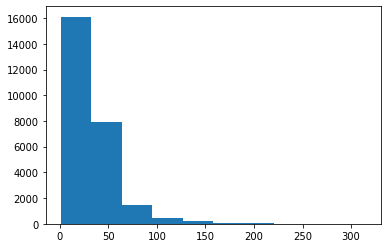

In [14]:
plt.hist(DALMP);

In [15]:
test = df.loc[21142:,['DATETIME','DALMP','LOGDALMP','MONTH','HOURENDING','SEASON','PEAKTYPE']]

In [16]:
test.head(2)

,DATETIME,DALMP,LOGDALMP,MONTH,HOURENDING,SEASON,PEAKTYPE
21142,2019-06-01 00:00:00,20.56,3.023347,6,24,3,0
21143,2019-06-01 01:00:00,18.11,2.896464,6,1,1,0


In [17]:
pred.head(2)

,ds,yhat,yhat_lower,yhat_upper,DALMP
0,2017-01-01 01:00:00,3.326183,2.968121,3.664869,27.831914
1,2017-01-01 02:00:00,3.275256,2.927455,3.608623,26.450002


In [18]:
pred_sub = pred.loc[21142:,]

In [19]:
pred_sub.head(2)

,ds,yhat,yhat_lower,yhat_upper,DALMP
21142,2019-06-01 00:00:00,2.825816,2.476993,3.154911,16.874713
21143,2019-06-01 01:00:00,2.827073,2.493514,3.176227,16.895935


#### MAE/MAPE out of bound

In [20]:
yhat_lower = pred_sub['yhat_lower'].values
yhat_upper = pred_sub['yhat_upper'].values

In [21]:
test_within = test[(test['LOGDALMP']>=yhat_lower) & (test['LOGDALMP']<=yhat_upper)]
print(len(test.index),len(test_within),len(test.index)-len(test_within),\
      (len(test.index)-len(test_within))/len(test.index),sep="  ")

5137  4281  856  0.1666342223087405


In [22]:
pred_sub_within = pred_sub[(test['LOGDALMP']>=yhat_lower) & (test['LOGDALMP']<=yhat_upper)]

In [23]:
MAE = mean_absolute_error(test_within['DALMP'].values,pred_sub_within['DALMP'].values)
MAE

3.8791380702530747

In [24]:
def MAPE(predict,target):
    return ( abs((target - predict) / target).mean()) * 100

print ('MAPE: ' + str(MAPE(test_within['DALMP'].values,pred_sub_within['DALMP'].values)))

MAPE: 15.198217555384975


#### MAE/MAPE out of three standard deviations

In [25]:
import statistics
from statistics import median
import astropy.stats 
from astropy.stats import median_absolute_deviation
med_dp = median(df['DALMP'])
mad_dp = median_absolute_deviation(df['DALMP'])
threshold_dp = med_dp+3*mad_dp  # calculate outlier cut-off

In [26]:
test2 = test[df['DALMP'] <= threshold_dp]
print(len(test)-len(test2.index),(len(test)-len(test2.index))/len(test),sep=" | ")

test2.head(2)


pred_sub2 = pred_sub[df['DALMP'] <= threshold_dp]

print(pred_sub2.shape)

190 | 0.03698656803581857
(4947, 5)


C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [27]:
# withou outliers
MAE = mean_absolute_error(test2.DALMP.values,pred_sub2.DALMP.values) 
MAE

4.941347198358659

In [28]:
def MAPE(predict,target):
    return ( abs((target - predict) / target).mean()) * 100

print ('MAPE: ' + str(MAPE(test2.DALMP.values,pred_sub2.DALMP.values)) )

MAPE: 19.44456796215201


### Hourly,peaktype,monthly error metrics below

#### Hourly MAE/MAPE

In [29]:
df.HOURENDING.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [30]:
dict_hourly_mae = {}
dict_hourly_mape = {}

In [31]:
def hourlyMAE(df1,df2,price,dict_mae,dict_mape):
    for i in range(1,25):
        _df1= df1[df1['HOURENDING'] == i]
        _df2= df2[df1['HOURENDING'] == i]
        
        MAE = mean_absolute_error(_df1[price].values,_df2[price].values) 
        
        dict_mae[str(i)] = MAE
        
        def MAPE(predict,target):
            MAPE = ( abs((target - predict) / target).mean()) * 100
            return MAPE

        dict_mape[str(i)] = MAPE(_df1[price].values,_df2[price].values)
        
        
    return dict_mae, dict_mape

In [32]:
hourlyMAE,hourlyMAPE = hourlyMAE(test2,pred_sub2,'DALMP',dict_hourly_mae,dict_hourly_mape)

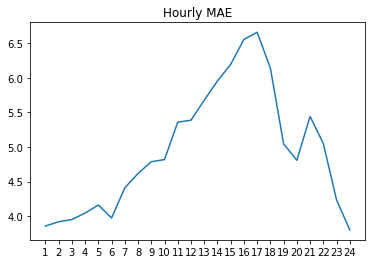

In [33]:
lists = hourlyMAE.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.title('Hourly MAE')
plt.plot(x, y)
plt.show()

8


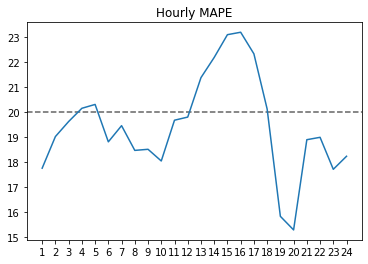

In [34]:
lists = hourlyMAPE.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
count = 0
for mape in y:
    if mape > 20:
        count+=1
print(count)
plt.title('Hourly MAPE')
plt.axhline(20, ls='--',color='#636363')
plt.plot(x, y)
plt.show()

#### On/Off Peak MAE/MAPE

In [35]:
dict_peak_mae = {}
dict_peak_mape = {}

In [36]:
def Peak_Type_MAE(df1,df2,price,dict_mae,dict_mape):
    for i in (0,1):
        _df1= df1[df1['PEAKTYPE'] == i]
        _df2= df2[df1['PEAKTYPE'] == i]
        
        MAE = mean_absolute_error(_df1[price].values,_df2[price].values) 
        
        dict_mae[str(i)] = MAE
        
        def MAPE(predict,target):
            MAPE = ( abs((target - predict) / target).mean()) * 100
            return MAPE

        dict_mape[str(i)] = MAPE(_df1[price].values,_df2[price].values)
        
        
    return dict_mae,dict_mape

In [37]:
pkMAE,pkMAPE=Peak_Type_MAE(test2,pred_sub2,'DALMP',dict_peak_mae,dict_peak_mape)

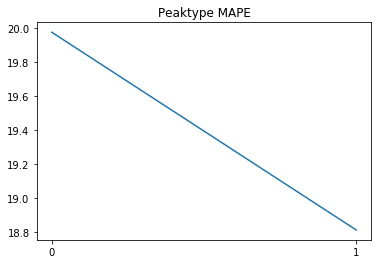

In [38]:
lists = pkMAPE.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.title('Peaktype MAPE')
plt.plot(x, y)
plt.show()

#### Monthly MAE/MAPE

In [39]:
test.MONTH.unique()

array([ 6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [40]:
def monthlyMAE_MAPE(df1,df2,price,dict_mae,dict_mape):
    for i in range(6,13):
        _df1= df1[df1['MONTH'] == i]
        _df2= df2[df1['MONTH'] == i]
        
        MAE = mean_absolute_error(_df1[price].values,_df2[price].values) 
        
        dict_mae[str(i)] = MAE
        
        def MAPE(predict,target):
            MAPE = ( abs((target - predict) / target).mean()) * 100
            return MAPE

        dict_mape[str(i)] = MAPE(_df1[price].values,_df2[price].values)
        
        
    return dict_mae, dict_mape

In [41]:
dict_month_mae = {}
dict_month_mape = {}

In [42]:
monthlyMAE,monthlyMAPE = monthlyMAE_MAPE(test2,pred_sub2,'DALMP',dict_month_mae,dict_month_mape)

4


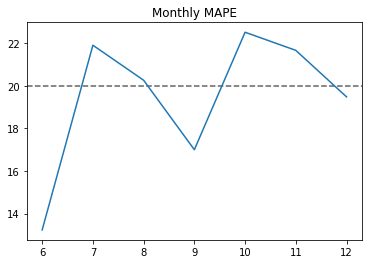

In [43]:
lists = monthlyMAPE.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

count = 0
for mape in y:
    if mape > 20:
        count+=1
print(count)
plt.axhline(20, ls='--',color='#636363')
plt.title('Monthly MAPE')
plt.plot(x, y)
# plt.text(1,3,'lol',ha="left", va="center", size=20)
plt.show()



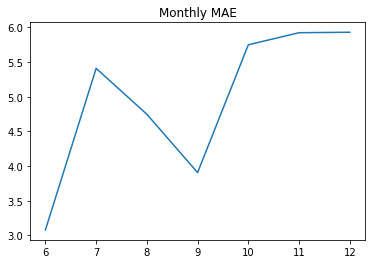

In [53]:
lists = monthlyMAE.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples



plt.title('Monthly MAE')
plt.plot(x, y)

plt.show()

